In [2]:
import torch
import numpy as np
import cv2
import random
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models

import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models

import torch
import numpy as np
import cv2
import random
import math
from torch.utils.data import Dataset, DataLoader


In [3]:
def make_curve_family(full_w: int, full_h: int, K: int) -> np.ndarray:
    """
    Generate K curves as y(x) centerlines.
    Output: ys shape [K, full_w] in pixel coords.
    """
    x = np.linspace(0, 1, full_w).astype(np.float32)

    # 1. Base trend: downward or upward
    trend = random.choice(["down", "up"])
    if trend == "down":
        base = (0.2 + 0.6 * (1 - x))
    else:
        base = (0.2 + 0.6 * x)

    # 2. Add smooth global curvature
    a1, a2 = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
    curve = base + a1 * np.sin(2 * math.pi * x * random.uniform(0.8, 1.8)) + \
                   a2 * np.sin(2 * math.pi * x * random.uniform(1.8, 3.2))

    # Scale to pixel range
    margin = random.uniform(0.1, 0.18)
    y0_px, y1_px = margin * full_h, (1 - margin) * full_h
    curve_px = y0_px + (y1_px - y0_px) * curve

    ys = np.zeros((K, full_w), np.float32)
    spacing = random.uniform(12, 30)
    offsets = np.linspace(-(K-1)/2, (K-1)/2, K) * spacing
    random.shuffle(offsets)

    for k in range(K):
        # Add per-series smooth warps
        warp = random.uniform(2, 16) * np.sin(2 * math.pi * x * random.uniform(0.6, 2.4) + random.uniform(0, 2*math.pi))
        ys[k] = curve_px + offsets[k] + warp

    # 3. Local Confusion: Force near-crossing or merging
    if K >= 2 and random.random() < 0.65:
        for _ in range(random.randint(1, 2)):
            a, b = random.sample(range(K), 2)
            cx = random.randint(full_w//5, 4*full_w//5)
            bw = random.randint(40, 120)
            lo, hi = max(0, cx-bw//2), min(full_w-1, cx+bw//2)

            t = np.linspace(-1, 1, hi-lo).astype(np.float32)
            blend = np.exp(-0.5 * (t / 0.4)**2) # Gaussian bell

            mid = 0.5 * (ys[a, lo:hi] + ys[b, lo:hi])
            if random.random() < 0.5:
                ys[a, lo:hi] = ys[a, lo:hi]*(1-blend) + mid*blend
                ys[b, lo:hi] = ys[b, lo:hi]*(1-blend) + mid*blend
            else: # Swap ordering locally
                ya, yb = ys[a, lo:hi].copy(), ys[b, lo:hi].copy()
                ys[a, lo:hi] = ya*(1-blend) + yb*blend
                ys[b, lo:hi] = yb*(1-blend) + ya*blend

    return np.clip(ys, 5, full_h-5)

class RealisticVariableSnapDataset(Dataset):
    def __init__(self, n_samples=5000, h=256, w=512, win_w=64, max_curves=8):
        self.n = n_samples
        self.h = h
        self.w = w
        self.win_w = win_w
        self.max_curves = max_curves

        # Configuration for realism (derived from SynthConfig)
        self.thickness_range = (1, 3)
        self.marker_prob = 0.4
        self.ci_prob = 0.25
        self.drift_prob = 0.6
        self.drift_amp_range = (4.0, 26.0)
        self.drift_smooth_sigma = (10.0, 35.0)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # 1. Randomly decide K for this sample
        num_curves = random.randint(1, self.max_curves)

        # 2. Generate Realistic Curve Family
        # We generate full-width curves first to calculate smooth drift
        ys_true = make_curve_family(self.w, self.h, num_curves)

        # 3. Generate Realistic Priors (Trajectories with Drift)
        # Instead of a heatmap, we generate 1D trajectories that 'drift' from the truth
        priors_full = self._build_drifted_priors(ys_true)

        # 4. Render Realistic Image
        # Includes JPEG noise, speckle, and background textures
        colors = [random_color_gen() for _ in range(num_curves)]
        full_img = render_full_image_no_axes_internal(self.h, self.w, ys_true, colors)

        # 5. Window Sampling (Vertical Strip)
        x_center = random.randint(self.win_w // 2, self.w - self.win_w // 2 - 1)
        x0, x1 = x_center - self.win_w // 2, x_center + self.win_w // 2

        rgb_win = full_img[:, x0:x1, :]

        # 6. Padding and Masking (Up to Max Curves)
        padded_priors = torch.zeros((self.max_curves, self.win_w))
        padded_targets = torch.zeros(self.max_curves)
        mask = torch.zeros(self.max_curves)

        for k in range(num_curves):
            # Prior for this window
            prior_segment = priors_full[k, x0:x1]
            padded_priors[k] = torch.from_numpy(prior_segment).float() / (self.h - 1)

            # Target is the centerline Y at the exact center column
            padded_targets[k] = torch.tensor(ys_true[k, x_center] / (self.h - 1)).float()
            mask[k] = 1.0

        img_t = torch.from_numpy(rgb_win).permute(2, 0, 1).float() / 255.0

        return img_t, padded_priors, padded_targets, mask

    def _build_drifted_priors(self, ys_true):
        K, W = ys_true.shape
        priors = ys_true.copy().astype(np.float32)

        for k in range(K):
            # Add base jitter
            priors[k] += np.random.normal(0, random.uniform(2.0, 5.0), size=W)

            # Add smooth correlated drift
            if random.random() < self.drift_prob:
                amp = random.uniform(*self.drift_amp_range)
                sig = random.uniform(*self.drift_smooth_sigma)
                priors[k] += smooth_random_drift_internal(W, amp, sig)

        return np.clip(priors, 0, self.h - 1)

# Helper functions for the realistic rendering pipeline
def smooth_random_drift_internal(W, amp, sigma):
    d = np.random.normal(0, 1, (W,)).astype(np.float32)
    d = cv2.GaussianBlur(d.reshape(1, -1), (0, 0), sigmaX=sigma).reshape(-1)
    d = d / (np.std(d) + 1e-6)
    return d * amp

def random_color_gen():
    return tuple(int(x) for x in np.random.randint(30, 220, size=3))

def render_full_image_no_axes_internal(H, W, ys, colors):
    img = np.ones((H, W, 3), np.uint8) * 255
    K = ys.shape[0]

    for k in range(K):
        color = colors[k]
        pts = np.stack([np.arange(W), ys[k]], axis=1).astype(np.int32)
        # Randomize linestyle
        style = random.choice(['solid', 'dashed', 'dotted'])
        if style == 'solid':
            cv2.polylines(img, [pts], False, color, 2, cv2.LINE_AA)
        elif style == 'dashed':
            for i in range(0, W-10, 20):
                cv2.polylines(img, [pts[i:i+12]], False, color, 2, cv2.LINE_AA)

        # Add realistic CI bars occasionally
        if random.random() < 0.25:
            for x in range(random.randint(0,20), W, random.randint(60, 100)):
                y = int(ys[k, x])
                cv2.line(img, (x, y-15), (x, y+15), color, 1, cv2.LINE_AA)

    # Add image-level noise (JPEG/Blur/Speckle)
    return add_image_noise_internal(img)

def add_image_noise_internal(img):
    # Quick implementation of the noise models from the new script
    out = img.copy()
    if random.random() < 0.3: # Blur
        out = cv2.GaussianBlur(out, (3, 3), 0)
    if random.random() < 0.3: # Speckle
        noise = np.random.normal(0, 5, out.shape).astype(np.uint8)
        out = cv2.add(out, noise)
    return out

In [4]:
import math
import random
from dataclasses import dataclass
from typing import List, Tuple

import cv2
import numpy as np
import torch
from torch.utils.data import Dataset


# =========================
# 1) Motif-based curve synthesis
# =========================

@dataclass
class Motif:
    kind: str
    length: int
    params: dict


def clamp(x, lo, hi):
    return max(lo, min(x, hi))


def _smooth1d(x: np.ndarray, k: int) -> np.ndarray:
    """Always returns same length as x, never crashes."""
    L = len(x)
    if L < 3:
        return x
    k = int(k) | 1
    k = min(k, L | 1)
    kernel = np.ones(k, np.float32) / k
    y = np.convolve(x, kernel, mode="same")
    return y[:L]

def safe_split(L: int, lo_frac=0.3, hi_frac=0.7) -> int:
    """Returns cut such that 1 <= cut <= L-1, or 0 if impossible."""
    if L < 2:
        return 0
    cut = int(L * random.uniform(lo_frac, hi_frac))
    return clamp(cut, 1, L - 1)

def _make_motif_sequence(W: int, km_like: bool) -> List[Motif]:
    """
    Generate an ordered list of motifs whose total length is approx W.
    KM-like = stepwise / plateau-dominated (NOT monotone).
    """
    seq: List[Motif] = []
    remaining = W

    if km_like:
        kinds = ["plateau", "jump", "stair", "kink", "spike", "osc"]
        weights = [0.32,     0.24,    0.22,    0.12,   0.04,    0.06]
    else:
        kinds = ["plateau", "ramp", "kink", "osc", "spike", "jump", "stair"]
        weights = [0.22,     0.20,   0.18,  0.18,  0.07,   0.08,   0.07]

    while remaining > 0:
        kind = random.choices(kinds, weights=weights, k=1)[0]

        if kind in ["jump", "spike"]:
            length = random.randint(6, 18)
        elif kind == "stair":
            length = random.randint(40, 130)
        else:
            length = random.randint(25, 120)

        length = min(length, remaining)

        params = {}
        if kind == "plateau":
            params["drift"] = random.uniform(-0.05, 0.05)

        elif kind == "ramp":
            params["dy"] = random.uniform(-50, 50)

        elif kind == "kink":
            params["dy1"] = random.uniform(-35, 35)
            params["dy2"] = random.uniform(-35, 35)

        elif kind == "jump":
            params["amp"] = random.uniform(15, 85) * random.choice([-1, 1])
            params["tilt"] = random.uniform(-0.15, 0.15)

        elif kind == "stair":
            params["n_steps"] = random.randint(3, 9)
            params["step_mag"] = random.uniform(8, 35) * random.choice([-1, 1])

        elif kind == "osc":
            params["amp"] = random.uniform(2.5, 14.0)
            params["rough"] = random.uniform(0.4, 1.0)
            params["bias"] = random.uniform(-0.08, 0.08)

        elif kind == "spike":
            params["amp"] = random.uniform(-60, 60)
            params["width"] = random.randint(7, 21) | 1

        seq.append(Motif(kind=kind, length=length, params=params))
        remaining -= length

    return seq

def _render_motifs_to_curve(W: int, H: int, seq: List[Motif], y0: float) -> np.ndarray:
    """
    Render motif sequence into a y(x) curve.
    Safe under all random seeds.
    """
    y = float(y0)
    out = np.zeros((W,), np.float32)

    i = 0
    for m in seq:
        lo = i
        hi = min(W, i + max(0, int(m.length)))
        L = hi - lo
        if L <= 0:
            break

        # ---------------- PLATEAU ----------------
        if m.kind == "plateau":
            drift = m.params["drift"]
            seg = y + np.linspace(0, drift * L, L)
            seg += np.random.normal(0, random.uniform(0.2, 0.9), L)

        # ---------------- RAMP ----------------
        elif m.kind == "ramp":
            seg = np.linspace(y, y + m.params["dy"], L)
            seg += _smooth1d(np.random.normal(0, 1.0, L), random.randint(5, 13))
            y = seg[-1]

        # ---------------- KINK ----------------
        elif m.kind == "kink":
            if L < 2:
                seg = np.full(L, y)
            else:
                cut = random.randint(1, L - 1)
                seg1 = np.linspace(y, y + m.params["dy1"], cut)
                seg2 = np.linspace(seg1[-1], seg1[-1] + m.params["dy2"], L - cut)
                seg = np.concatenate([seg1, seg2])
                seg += _smooth1d(np.random.normal(0, 1.0, L), random.randint(3, 9))
                y = seg[-1]

        # ---------------- JUMP ----------------
        elif m.kind == "jump":
            fall = random.randint(1, min(10, L))
            seg1 = np.linspace(
                y,
                y + m.params["amp"] + m.params["tilt"] * fall,
                fall,
            )
            seg2 = np.full(L - fall, seg1[-1])
            seg = np.concatenate([seg1, seg2])
            seg += _smooth1d(np.random.normal(0, 1.0, L), 5)
            y = seg[-1]

        # ---------------- STAIR ----------------
        elif m.kind == "stair":
            n = m.params["n_steps"]
            step = m.params["step_mag"]
            cuts = np.linspace(0, L, n + 1).astype(int)
            segs = []
            yy = y
            for a, b in zip(cuts[:-1], cuts[1:]):
                segs.append(np.full(b - a, yy))
                yy += step * random.uniform(0.6, 1.4)
            seg = np.concatenate(segs)[:L]
            seg += np.random.normal(0, random.uniform(0.15, 0.8), L)
            if random.random() < 0.35:
                seg += np.linspace(0, random.uniform(-1.5, 1.5), L)
            y = seg[-1]

        # ---------------- OSC ----------------
        elif m.kind == "osc":
            base = y + np.linspace(0, m.params["bias"] * L, L)
            n = _smooth1d(np.random.normal(0, 1.0, L), random.randint(7, 21))
            mod = _smooth1d(np.random.normal(0, 1.0, L), random.randint(9, 31))
            mod = (mod - mod.min()) / (mod.std() + 1e-6)
            seg = base + (n * (m.params["amp"] * (0.4 + 0.6 * np.tanh(mod)))) * m.params["rough"]
            seg += np.random.normal(0, random.uniform(0.5, 2.2), L)
            y = seg[-1]

        elif m.kind == "spike":
            amp = float(m.params["amp"])

            # Choose an odd width <= L
            width = int(m.params["width"])
            width = max(1, width)
            width = min(width, L)
            if width % 2 == 0:
                width -= 1
            width = max(1, width)

            seg = np.full((L,), y, np.float32)

            if width == 1:
                seg[random.randint(0, L - 1)] += amp
            else:
                x = np.linspace(-1.0, 1.0, width, dtype=np.float32)
                bump = (amp * np.exp(-6.0 * (x ** 2))).astype(np.float32)

                c = random.randint(0, L - 1)
                w2 = width // 2

                # Destination slice
                a = max(0, c - w2)
                b = min(L, c + w2 + 1)
                dst_len = b - a
                if dst_len <= 0:
                    # Extremely defensive fallback
                    seg[c] += amp
                else:
                    # Source slice constructed to match dst_len exactly
                    sa = w2 - (c - a)
                    sb = sa + dst_len

                    # Clamp to bump bounds, then clamp dst accordingly to keep same length
                    sa_clamped = max(0, sa)
                    sb_clamped = min(width, sb)

                    src_len = sb_clamped - sa_clamped
                    if src_len <= 0:
                        seg[c] += amp
                    else:
                        # Adjust destination length to match clamped source length
                        b2 = a + src_len
                        seg[a:b2] += bump[sa_clamped:sb_clamped]

            seg += np.random.normal(0, random.uniform(0.4, 1.8), L).astype(np.float32)

        else:
            seg = np.full(L, y)

        out[lo:hi] = seg
        y = float(seg[-1])
        i = hi

    # -------- Global smooth warp --------
    if random.random() < 0.35:
        warp = _smooth1d(np.random.normal(0, 1.0, W), random.randint(15, 41))
        warp = warp / (warp.std() + 1e-6) * random.uniform(0.2, 1.2)
        out += warp

    return np.clip(out, 5, H - 5).astype(np.float32)

def make_curve_family(full_w: int, full_h: int, K: int) -> np.ndarray:
    """
    Generate K related curves with shared motif structure and local interactions.
    """
    ys = np.zeros((K, full_w), np.float32)

    km_like = random.random() < 0.5
    base_seq = _make_motif_sequence(full_w, km_like)

    spacing = random.uniform(12, 30)
    offsets = np.linspace(-(K - 1) / 2, (K - 1) / 2, K) * spacing
    random.shuffle(offsets)

    for k in range(K):
        seq = []
        for m in base_seq:
            mp = dict(m.params)
            if m.kind in ["jump", "ramp", "kink", "stair", "osc", "spike"]:
                jitter = random.uniform(0.85, 1.15)
                for kk, vv in mp.items():
                    if isinstance(vv, (int, float)) and kk not in ["width", "n_steps"]:
                        mp[kk] = vv * jitter
            seq.append(Motif(m.kind, m.length, mp))

        y_start = random.uniform(0.2, 0.8) * full_h + offsets[k] + random.uniform(-6, 6)
        ys[k] = _render_motifs_to_curve(full_w, full_h, seq, y_start)

    # -------- Local interactions --------
    if K >= 2 and random.random() < 0.70:
        for _ in range(random.randint(1, 3)):
            a, b = random.sample(range(K), 2)
            cx = random.randint(full_w // 6, 5 * full_w // 6)
            bw = random.randint(35, 140)
            lo, hi = max(0, cx - bw // 2), min(full_w, cx + bw // 2)
            t = np.linspace(-1, 1, hi - lo)
            blend = np.exp(-0.5 * (t / random.uniform(0.25, 0.55)) ** 2)

            if random.random() < 0.55:
                mid = 0.5 * (ys[a, lo:hi] + ys[b, lo:hi])
                ys[a, lo:hi] = ys[a, lo:hi] * (1 - blend) + mid * blend
                ys[b, lo:hi] = ys[b, lo:hi] * (1 - blend) + mid * blend
            else:
                ya, yb = ys[a, lo:hi].copy(), ys[b, lo:hi].copy()
                ys[a, lo:hi] = ya * (1 - blend) + yb * blend
                ys[b, lo:hi] = yb * (1 - blend) + ya * blend

    return np.clip(ys, 5, full_h - 5)


# =========================
# 2) Background + rendering realism (no axes, but realistic "plot image")
# =========================

def random_color_gen():
    # avoid extremely bright/white-like strokes
    return tuple(int(x) for x in np.random.randint(25, 230, size=3))

def _make_background(H: int, W: int) -> np.ndarray:
    """
    Realistic background: off-white/gray base, gentle gradients, paper/scan texture,
    speckle, faint banding. No grid/axes by default.
    """
    # base tone
    base = random.randint(235, 255)
    img = np.ones((H, W, 3), np.uint8) * base

    # gentle illumination gradient (scanner / camera)
    if random.random() < 0.85:
        gx = np.linspace(0, 1, W, dtype=np.float32)
        gy = np.linspace(0, 1, H, dtype=np.float32)
        Gx, Gy = np.meshgrid(gx, gy)
        ang = random.uniform(0, 2 * math.pi)
        grad = (math.cos(ang) * Gx + math.sin(ang) * Gy).astype(np.float32)
        grad = (grad - grad.min()) / (grad.max() - grad.min() + 1e-6)
        strength = random.uniform(2.0, 18.0)
        img = np.clip(img.astype(np.float32) - strength * (grad[..., None] - 0.5), 0, 255).astype(np.uint8)

    # paper texture: blurred noise field
    if random.random() < 0.80:
        tex = np.random.normal(0, 1.0, (H, W)).astype(np.float32)
        sig = random.uniform(6.0, 22.0)
        tex = cv2.GaussianBlur(tex, (0, 0), sigmaX=sig, sigmaY=sig)
        tex = tex / (tex.std() + 1e-6)
        amp = random.uniform(1.0, 6.0)
        img = np.clip(img.astype(np.float32) + amp * tex[..., None], 0, 255).astype(np.uint8)

    # faint banding (printer/scan lines)
    if random.random() < 0.25:
        band = np.random.normal(0, 1.0, (H, 1)).astype(np.float32)
        band = cv2.GaussianBlur(band, (1, 0), sigmaX=0, sigmaY=random.uniform(5.0, 25.0))
        band = band / (band.std() + 1e-6)
        img = np.clip(img.astype(np.float32) + random.uniform(0.5, 2.5) * band[..., None], 0, 255).astype(np.uint8)

    return img

def _draw_polyline_styled(img: np.ndarray, pts: np.ndarray, color: Tuple[int, int, int], thickness: int, style: str):
    """Draw solid/dashed/dotted polyline with OpenCV."""
    W = img.shape[1]

    if style == "solid":
        cv2.polylines(img, [pts], False, color, thickness, cv2.LINE_AA)
        return

    if style == "dashed":
        dash = random.randint(10, 18)
        gap = random.randint(8, 16)
        i = 0
        while i < W - 1:
            j = min(W, i + dash)
            cv2.polylines(img, [pts[i:j]], False, color, thickness, cv2.LINE_AA)
            i = j + gap
        return

    if style == "dotted":
        step = random.randint(10, 18)
        r = max(1, thickness // 2)
        for i in range(0, W, step):
            x, y = int(pts[i, 0]), int(pts[i, 1])
            cv2.circle(img, (x, y), r, color, -1, cv2.LINE_AA)
        return

    # fallback
    cv2.polylines(img, [pts], False, color, thickness, cv2.LINE_AA)


def _draw_markers(img, pts, color, thickness):
    """
    Tracking-safe markers:
    - max total height <= 4 px
    - independent of line thickness
    """
    marker_step = random.randint(30, 70)

    size = random.randint(1, 2)   # radius / half-size
    size = min(size, 2)           # hard clamp

    kind = random.choice(["circle", "square", "triangle", "x"])

    for i in range(0, len(pts), marker_step):
        x, y = int(pts[i, 0]), int(pts[i, 1])

        if kind == "circle":
            cv2.circle(img, (x, y), size, color, 1, cv2.LINE_AA)

        elif kind == "square":
            cv2.rectangle(
                img,
                (x - size, y - size),
                (x + size, y + size),
                color,
                1,
                cv2.LINE_AA,
            )

        elif kind == "triangle":
            tri = np.array(
                [[x, y - size], [x - size, y + size], [x + size, y + size]],
                np.int32,
            )
            cv2.polylines(img, [tri], True, color, 1, cv2.LINE_AA)

        else:  # 'x'
            cv2.line(img, (x - size, y - size), (x + size, y + size), color, 1, cv2.LINE_AA)
            cv2.line(img, (x - size, y + size), (x + size, y - size), color, 1, cv2.LINE_AA)

def _draw_ci_band(img: np.ndarray, y: np.ndarray, color: Tuple[int, int, int], alpha: float = 0.18):
    """Shaded confidence band around a curve (more realistic than vertical bars)."""
    H, W = img.shape[:2]
    # band width varies smoothly
    bw = np.random.normal(0, 1.0, W).astype(np.float32)
    bw = cv2.GaussianBlur(bw.reshape(1, -1), (0, 0), sigmaX=random.uniform(10, 35)).reshape(-1)
    bw = bw / (bw.std() + 1e-6)
    half = np.clip(3 + 2 * bw, 2, 8).astype(np.int32)

    y0 = np.clip(y.astype(np.int32) - half, 0, H - 1)
    y1 = np.clip(y.astype(np.int32) + half, 0, H - 1)

    upper = np.stack([np.arange(W), y0], axis=1)
    lower = np.stack([np.arange(W)[::-1], y1[::-1]], axis=1)
    poly = np.concatenate([upper, lower], axis=0).astype(np.int32)

    overlay = img.copy()
    cv2.fillPoly(overlay, [poly], color)
    cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, dst=img)

def _draw_legend_box(img: np.ndarray, colors: List[Tuple[int, int, int]], labels: List[str]):
    """
    Black box somewhere with text; includes small color swatches.
    Intentionally can occlude curves to improve tracking robustness.
    """
    H, W = img.shape[:2]
    n = min(len(labels), random.randint(1, min(6, len(labels))))
    idxs = random.sample(range(len(labels)), n)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = random.uniform(0.35, 0.55)
    thick = 1

    line_h = int(18 * font_scale + 10)
    box_w = random.randint(int(W * 0.18), int(W * 0.35))
    box_h = int(12 + n * line_h)

    # random placement
    x0 = random.randint(0, max(0, W - box_w - 1))
    y0 = random.randint(0, max(0, H - box_h - 1))

    overlay = img.copy()
    # black (or very dark) box with slight transparency
    cv2.rectangle(overlay, (x0, y0), (x0 + box_w, y0 + box_h), (0, 0, 0), -1)
    cv2.addWeighted(overlay, random.uniform(0.65, 0.9), img, 1 - random.uniform(0.65, 0.9), 0, dst=img)

    # draw entries
    y = y0 + 10 + int(line_h * 0.7)
    for j, i in enumerate(idxs):
        c = colors[i]
        # swatch line
        cv2.line(img, (x0 + 10, y - 5), (x0 + 40, y - 5), c, 2, cv2.LINE_AA)
        # label
        cv2.putText(img, labels[i], (x0 + 48, y),
                    font, font_scale, (255, 255, 255), thick, cv2.LINE_AA)
        y += line_h

def add_image_noise_internal(img: np.ndarray) -> np.ndarray:
    """
    Image-level artifacts: blur, sensor noise, salt/pepper, jpeg compression.
    """
    out = img.copy()

    # Mild blur (camera focus / JPEG smoothing)
    if random.random() < 0.35:
        k = random.choice([3, 5])
        out = cv2.GaussianBlur(out, (k, k), 0)

    # Additive sensor noise (Gaussian)
    if random.random() < 0.60:
        sigma = random.uniform(1.0, 6.0)
        noise = np.random.normal(0, sigma, out.shape).astype(np.float32)
        out = np.clip(out.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    # Speckle / multiplicative-ish
    if random.random() < 0.35:
        s = random.uniform(0.01, 0.05)
        n = np.random.normal(0, 1.0, out.shape).astype(np.float32)
        out = np.clip(out.astype(np.float32) + out.astype(np.float32) * (s * n), 0, 255).astype(np.uint8)

    # Salt & pepper
    if random.random() < 0.15:
        p = random.uniform(0.0005, 0.003)
        mask = np.random.rand(*out.shape[:2])
        out[mask < p] = 0
        out[mask > 1 - p] = 255

    # JPEG compression artifacts
    if random.random() < 0.55:
        q = random.randint(35, 90)
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]
        ok, enc = cv2.imencode(".jpg", out, encode_param)
        if ok:
            out = cv2.imdecode(enc, cv2.IMREAD_COLOR)

    return out

def render_full_image_no_axes_internal(
    H: int,
    W: int,
    ys: np.ndarray,
    colors: List[Tuple[int, int, int]],
    thickness_range=(1, 3),
    marker_prob=0.40,
    ci_prob=0.30,
    legend_prob=0.35,
) -> np.ndarray:
    """
    Render curves on realistic background (no axes), with optional CI bands, markers, and legend box.
    """
    img = _make_background(H, W)
    K = ys.shape[0]

    # Labels for legend (simple but realistic)
    label_pool = ["Control", "Treatment", "Model A", "Model B", "Group 1", "Group 2", "Baseline", "Variant"]
    labels = []
    for k in range(K):
        if random.random() < 0.7:
            labels.append(random.choice(label_pool))
        else:
            labels.append(f"Series {k+1}")

    # Draw confidence bands first (under curves)
    for k in range(K):
        if random.random() < ci_prob:
            _draw_ci_band(img, ys[k], colors[k], alpha=random.uniform(0.10, 0.22))

    for k in range(K):
        color = colors[k]
        thickness = random.randint(*thickness_range)
        pts = np.stack([np.arange(W), ys[k]], axis=1).astype(np.int32)

        style = random.choices(["solid", "dashed", "dotted"], weights=[0.62, 0.25, 0.13], k=1)[0]
        _draw_polyline_styled(img, pts, color, thickness, style)

        # Markers: low probability and low density
        if random.random() < marker_prob:
            _draw_markers(img, pts, color, thickness)

        # Occasional tiny occluders (tracking realism): small smudges / overdraw
        if random.random() < 0.12:
            x = random.randint(0, W - 1)
            y = int(np.clip(ys[k, x], 0, H - 1))
            r = random.randint(6, 16)
            sm = img.copy()
            cv2.circle(sm, (x, y), r, (random.randint(0, 40),) * 3, -1, cv2.LINE_AA)
            cv2.addWeighted(sm, random.uniform(0.10, 0.30), img, 1 - random.uniform(0.10, 0.30), 0, dst=img)

    # Legend box (can occlude curves)
    if K >= 1 and random.random() < legend_prob:
        _draw_legend_box(img, colors, labels)

    img = add_image_noise_internal(img)
    return img


# =========================
# 3) Priors for tracking (drift + structural mistakes)
# =========================

def smooth_random_drift_internal(W, amp, sigma):
    d = np.random.normal(0, 1, (W,)).astype(np.float32)
    d = cv2.GaussianBlur(d.reshape(1, -1), (0, 0), sigmaX=sigma).reshape(-1)
    d = d / (np.std(d) + 1e-6)
    return d * amp


# =========================
# 4) Dataset (same interface as yours)
# =========================
class RealisticVariableSnapDataset(Dataset):
    """
    mode = "full"   -> returns full image + full priors + full targets
    mode = "window" -> returns cropped window (your original tracking setup)
    """

    def __init__(
        self,
        n_samples=5000,
        h=256,
        w=512,
        win_w=64,
        max_curves=8,
        mode="window",  # "window" or "full"
    ):
        assert mode in ["window", "full"]
        self.mode = mode

        self.n = n_samples
        self.h = h
        self.w = w
        self.win_w = win_w
        self.max_curves = max_curves

        # Rendering realism
        self.thickness_range = (2, 5)
        self.marker_prob = 0.45
        self.ci_prob = 0.35
        self.legend_prob = 0.40

        # Tracking priors
        self.drift_prob = 0.70
        self.drift_amp_range = (4.0, 28.0)
        self.drift_smooth_sigma = (10.0, 40.0)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # -------------------------------------------------
        # 1) Generate full scene (always)
        # -------------------------------------------------
        num_curves = random.randint(1, self.max_curves)
        ys_true = make_curve_family(self.w, self.h, num_curves)
        priors_full = self._build_drifted_priors(ys_true)

        colors = [random_color_gen() for _ in range(num_curves)]
        full_img = render_full_image_no_axes_internal(
            self.h,
            self.w,
            ys_true,
            colors,
            thickness_range=self.thickness_range,
            marker_prob=self.marker_prob,
            ci_prob=self.ci_prob,
            legend_prob=self.legend_prob,
        )

        # -------------------------------------------------
        # 2) Return FULL mode
        # -------------------------------------------------
        if self.mode == "full":
            # Pad priors/targets to max_curves for batching consistency
            padded_priors = torch.zeros((self.max_curves, self.w))
            padded_targets = torch.zeros((self.max_curves, self.w))
            mask = torch.zeros(self.max_curves)

            for k in range(num_curves):
                padded_priors[k] = torch.from_numpy(priors_full[k]).float() / (self.h - 1)
                padded_targets[k] = torch.from_numpy(ys_true[k]).float() / (self.h - 1)
                mask[k] = 1.0

            img_t = torch.from_numpy(full_img).permute(2, 0, 1).float() / 255.0
            return img_t, padded_priors, padded_targets, mask

        # -------------------------------------------------
        # 3) Return WINDOW mode (tracking)
        # -------------------------------------------------
        x_center = random.randint(self.win_w // 2, self.w - self.win_w // 2 - 1)
        x0, x1 = x_center - self.win_w // 2, x_center + self.win_w // 2

        rgb_win = full_img[:, x0:x1, :]

        padded_priors = torch.zeros((self.max_curves, self.win_w))
        padded_targets = torch.zeros(self.max_curves)
        mask = torch.zeros(self.max_curves)

        for k in range(num_curves):
            padded_priors[k] = torch.from_numpy(priors_full[k, x0:x1]).float() / (self.h - 1)
            padded_targets[k] = torch.tensor(ys_true[k, x_center] / (self.h - 1)).float()
            mask[k] = 1.0

        img_t = torch.from_numpy(rgb_win).permute(2, 0, 1).float() / 255.0
        return img_t, padded_priors, padded_targets, mask

    def _build_drifted_priors(self, ys_true: np.ndarray) -> np.ndarray:
        K, W = ys_true.shape
        priors = ys_true.copy().astype(np.float32)

        for k in range(K):
            priors[k] += np.random.normal(0, random.uniform(1.0, 4.0), size=W).astype(np.float32)

            if random.random() < self.drift_prob:
                amp = random.uniform(*self.drift_amp_range)
                sig = random.uniform(*self.drift_smooth_sigma)
                priors[k] += smooth_random_drift_internal(W, amp, sig)

        return np.clip(priors, 0, self.h - 1)



In [5]:
class VariableCurveSnapperNet(nn.Module):
    def __init__(self, win_w=64, max_curves=8):
        super().__init__()
        base = models.resnet18(weights='DEFAULT')
        base.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.compress = nn.Sequential(nn.Conv2d(512, 128, 1), nn.BatchNorm2d(128), nn.ReLU())

        # Prior Encoder handles [Batch, 8, win_w]
        self.prior_mlp = nn.Sequential(
            nn.Linear(max_curves * win_w, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.regressor = nn.Sequential(
            nn.Linear(128 * 8 * 2 + 256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, max_curves), # Always output 8 values
            nn.Sigmoid()
        )

    def forward(self, img, priors):
        b, _, h, w = img.shape
        y_map = torch.linspace(0, 1, h, device=img.device).view(1, 1, h, 1).expand(b, 1, h, w)
        x = torch.cat([img, y_map], dim=1)

        v_feat = self.compress(self.backbone(x)).flatten(1)
        p_feat = self.prior_mlp(priors.view(b, -1))

        return self.regressor(torch.cat([v_feat, p_feat], dim=1))

In [15]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def snapping_refined_loss(output, targets, priors, masks, h=256, trust_threshold=5.0):
    """
    Custom loss that penalizes moving away from a 'good' prior while 
    encouraging snapping to the curve.
    """
    # Convert to pixel space
    out_px = output * h
    target_px = targets * h
    # Extract the prior value at the center column (index 32 of win_w=64)
    prior_px = priors[:, :, 32] * h 

    # 1. Basic Snapping Loss (Pull toward Ground Truth)
    snap_loss = torch.nn.functional.smooth_l1_loss(out_px, target_px, reduction='none')

    # 2. Prior Consistency Penalty
    movement = torch.abs(out_px - prior_px)
    prior_error = torch.abs(prior_px - target_px)

    # Calculate 'Trust' weight: High if prior is already near GT
    weight_prior = torch.exp(-prior_error / trust_threshold)
    
    # Penalize movement only when the prior was already accurate
    consistency_loss = weight_prior * movement

    # Total loss combining snapping and consistency
    total_loss = snap_loss + (1.5 * consistency_loss) 
    
    return (total_loss * masks).sum() / (masks.sum() + 1e-8)

def train_snapper(model, val_loader, epochs=20, window_size=64, window_height=256, patience=10):
    print("there")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # OneCycleLR manages the learning rate 'warm-up' and 'cool-down'
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-4,
        steps_per_epoch=1,
        epochs=epochs
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_px_err = 1e9
    epochs_no_improve = 0
    
    print(f"Starting Training on {device}")
    
    for epoch in range(epochs):
        # Regenerate fresh data every epoch
        train_dataset = RealisticVariableSnapDataset(n_samples=10000, win_w=window_size, h=window_height)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        model.train()
        total_train_loss = 0
        
        # tqdm bar for the training epoch
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for imgs, priors, targets, masks in pbar:
            imgs, priors, targets, masks = imgs.to(device), priors.to(device), targets.to(device), masks.to(device)

            optimizer.zero_grad()
            output = model(imgs, priors)

            # Apply the Refined Snapping Loss
            loss = snapping_refined_loss(output, targets, priors, masks, h=window_height)
            
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            # Update progress bar with the current batch loss
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        # --- Validation Phase ---
        model.eval()
        total_val_px_err = 0
        val_curve_count = 0
        
        with torch.no_grad():
            for imgs, priors, targets, masks in val_loader:
                imgs, priors, targets, masks = imgs.to(device), priors.to(device), targets.to(device), masks.to(device)

                output = model(imgs, priors)
                # Validation uses pure Pixel Error metric
                abs_diff = torch.abs(output * window_height - targets * window_height)

                total_val_px_err += (abs_diff * masks).sum().item()
                val_curve_count += masks.sum().item()

        avg_train = total_train_loss / len(train_loader)
        avg_val_px_err = total_val_px_err / (val_curve_count + 1e-8)

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # --- Early Stopping & Saving ---
        if avg_val_px_err < best_val_px_err:
            best_val_px_err = avg_val_px_err
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_snapper.pth")
            status = f"(Best! Val Error: {avg_val_px_err:.2f}px)"
        else:
            epochs_no_improve += 1
            status = f"(No improve for {epochs_no_improve} epochs)"

        print(f"Summary | LR: {current_lr:.6f} | Train Loss: {avg_train:.4f} | Val Err: {avg_val_px_err:.2f}px {status}")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered. No improvement for {patience} epochs.")
            break

    # Load the best weights before returning
    model.load_state_dict(torch.load("best_snapper.pth"))
    return model

In [7]:
def visualize_snapping(model, dataset, num_samples=3):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import random

    model.eval()
    device = next(model.parameters()).device
    h, win_w = dataset.h, dataset.win_w
    center_x = win_w // 2

    # Using 'tab10' colormap for up to 8 distinct, high-contrast colors
    colors = cm.get_cmap('tab10', 8)

    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 6 * num_samples))
    if num_samples == 1: axes = [axes]

    with torch.no_grad():
        for i in range(num_samples):
            # 1. Get random sample and send to device
            idx = random.randint(0, len(dataset)-1)
            img_t, priors_t, targets_t, mask = dataset[idx]

            # 2. Prediction (Expects [1, 8, win_w])
            output = model(img_t.unsqueeze(0).to(device), priors_t.unsqueeze(0).to(device))
            preds_px = output.squeeze().cpu().numpy() * h

            # 3. Prep coordinates for plotting
            img_np = img_t.permute(1, 2, 0).cpu().numpy()
            priors_px = priors_t.cpu().numpy() * h
            targets_px = targets_t.cpu().numpy() * h
            x_axis = np.arange(win_w)

            axes[i].imshow(img_np)

            # 4. Iterate through the mask to only plot the actual data
            num_active = int(mask.sum().item())
            total_err = 0

            for j in range(num_active):
                c = colors(j)
                err_px = abs(preds_px[j] - targets_px[j])
                total_err += err_px

                # Plot the drifted Prior Trajectory (Dashed/Transparent)
                axes[i].plot(x_axis, priors_px[j], color=c, linestyle='--', alpha=0.4, linewidth=1)

                # Plot the Ground Truth (Small circle)
                axes[i].scatter(center_x, targets_px[j], color=c, s=100,
                                edgecolors='white', linewidth=1.5, zorder=5)

                # Plot the Model Prediction (Bright Star)
                axes[i].scatter(center_x, preds_px[j], color=c, marker='*', s=200,
                                edgecolors='black', linewidth=1, zorder=6)

                # Label the Pixel Difference next to the snap
                axes[i].text(center_x + 3, preds_px[j], f"{err_px:.1f}px",
                             color=c, fontsize=10, fontweight='bold',
                             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

            avg_err = total_err / num_active if num_active > 0 else 0
            axes[i].set_title(f"Sample {idx} | Curves: {num_active} | Avg Snap Error: {avg_err:.2f}px")

    plt.tight_layout()
    plt.show()

In [16]:
# --- SETTINGS ---
H = 256
WIN_W = 64
BATCH_SIZE = 32
EPOCHS = 10

# 1. Initialize Datasets (Separate samples for Train and Val)
val_dataset = RealisticVariableSnapDataset(n_samples=1000)

# 2. Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 3. Initialize Model
model = VariableCurveSnapperNet(win_w=WIN_W)

# 4. START TRAINING WITH VALIDATION
print("Starting training with validation...")
trained_model = train_snapper(
    model,
    val_loader,
    epochs=EPOCHS,
    window_size=WIN_W
)

# 5. SAVE AND TEST
torch.save(trained_model.state_dict(), "curve_snapper_validated.pth")

Starting training with validation...
there
Starting Training on cuda


Epoch 1/10: 100%|██████████| 313/313 [03:30<00:00,  1.49batch/s, loss=66.3357] 


Summary | LR: 0.000052 | Train Loss: 94.1173 | Val Err: 45.63px (Best! Val Error: 45.63px)


Epoch 2/10: 100%|██████████| 313/313 [03:42<00:00,  1.41batch/s, loss=24.2115]


Summary | LR: 0.000100 | Train Loss: 37.7497 | Val Err: 14.73px (Best! Val Error: 14.73px)


Epoch 3/10: 100%|██████████| 313/313 [03:41<00:00,  1.41batch/s, loss=25.0247]


Summary | LR: 0.000095 | Train Loss: 25.0600 | Val Err: 12.36px (Best! Val Error: 12.36px)


Epoch 4/10: 100%|██████████| 313/313 [03:44<00:00,  1.39batch/s, loss=21.5764]


Summary | LR: 0.000081 | Train Loss: 22.7488 | Val Err: 12.12px (Best! Val Error: 12.12px)


Epoch 5/10: 100%|██████████| 313/313 [03:40<00:00,  1.42batch/s, loss=23.3417]


Summary | LR: 0.000061 | Train Loss: 20.6626 | Val Err: 11.72px (Best! Val Error: 11.72px)


Epoch 6/10: 100%|██████████| 313/313 [03:43<00:00,  1.40batch/s, loss=22.0277]


Summary | LR: 0.000039 | Train Loss: 19.3651 | Val Err: 10.76px (Best! Val Error: 10.76px)


Epoch 7/10: 100%|██████████| 313/313 [03:46<00:00,  1.38batch/s, loss=18.1964]


Summary | LR: 0.000019 | Train Loss: 17.7201 | Val Err: 9.97px (Best! Val Error: 9.97px)


Epoch 8/10: 100%|██████████| 313/313 [03:44<00:00,  1.40batch/s, loss=24.4190]


Summary | LR: 0.000005 | Train Loss: 16.9486 | Val Err: 10.05px (No improve for 1 epochs)


Epoch 9/10: 100%|██████████| 313/313 [03:44<00:00,  1.40batch/s, loss=16.8918]


Summary | LR: 0.000000 | Train Loss: 16.4684 | Val Err: 9.94px (Best! Val Error: 9.94px)


Epoch 10/10: 100%|██████████| 313/313 [03:41<00:00,  1.41batch/s, loss=19.9636]


Summary | LR: 0.000005 | Train Loss: 16.4873 | Val Err: 9.72px (Best! Val Error: 9.72px)


In [17]:
# --- SETTINGS ---
H = 256
WIN_W = 64
BATCH_SIZE = 32
EPOCHS = 50

# 1. Initialize Datasets (Separate samples for Train and Val)
val_dataset = RealisticVariableSnapDataset(n_samples=1000)

# 2. Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


In [20]:
def compute_pixel_metrics(model, loader, device, h=256):
    model.eval()
    all_errors = []

    with torch.no_grad():
        for imgs, priors, targets, masks in loader:
            imgs, priors, targets, masks = imgs.to(device), priors.to(device), targets.to(device), masks.to(device)

            # Get model output [Batch, 8]
            output = model(imgs, priors)

            # Convert to pixel coordinates
            output_px = output * h
            targets_px = targets * h

            # Compute absolute difference
            abs_diff = torch.abs(output_px - targets_px) # [Batch, 8]

            # Extract only the errors for active curves using the mask
            # .masked_select returns a 1D tensor of only the "True" values
            active_errors = torch.masked_select(abs_diff, masks.bool())

            all_errors.append(active_errors.cpu())

    if not all_errors:
        return 0.0, 0.0

    # Combine all individual curve errors into one large 1D tensor
    all_errors_tensor = torch.cat(all_errors)

    mean_error = torch.mean(all_errors_tensor).item()
    median_error = torch.median(all_errors_tensor).item()

    return mean_error, median_error

# Usage:
mean_err, median_err = compute_pixel_metrics(trained_model, val_loader, "cuda", h=256)
print(f"Mean Error: {mean_err:.2f}px | Median Error: {median_err:.2f}px")

Mean Error: 10.39px | Median Error: 7.33px


C:\Users\remi_\AppData\Local\Temp\ipykernel_8188\3500545963.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', 8)


RuntimeError: Given groups=1, weight of size [64, 2, 7, 7], expected input[1, 4, 256, 64] to have 2 channels, but got 4 channels instead

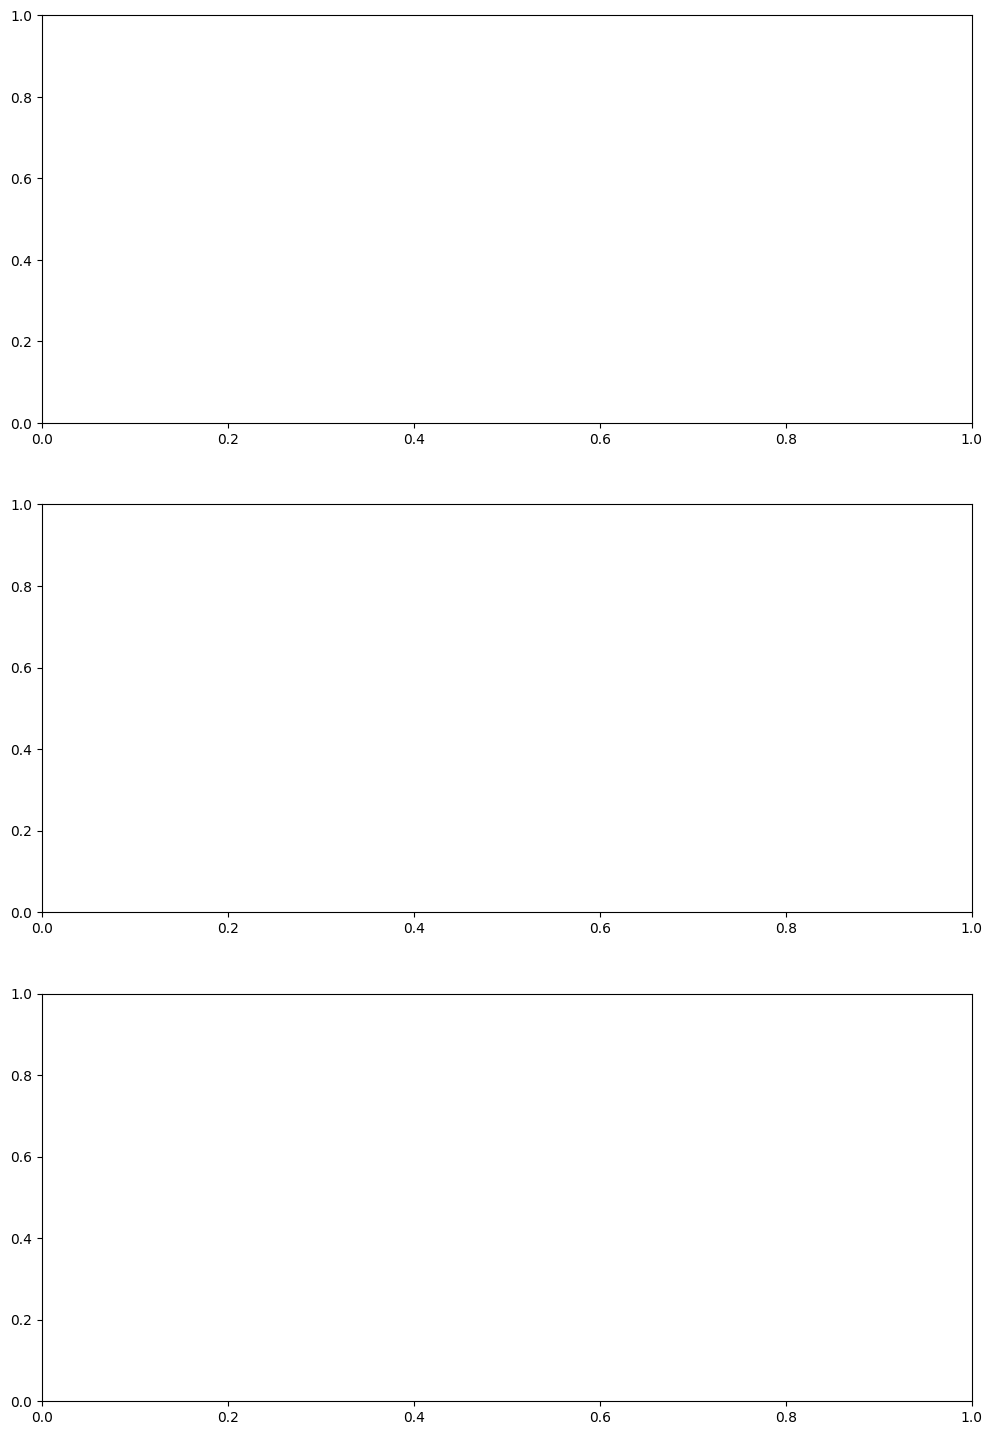

In [41]:
visualize_snapping(model, val_dataset)

In [24]:
import torch

def load_variable_curve_snapper_weights(
    model,
    pth_path,
    device="cpu",
    strict=True,
):
    """
    Load pretrained weights into a VariableCurveSnapperNet model.

    Args:
        model (nn.Module): Initialized VariableCurveSnapperNet instance.
        pth_path (str): Path to the .pth file.
        device (str or torch.device): Device to map weights to.
        strict (bool): Whether to enforce exact key matching.

    Returns:
        nn.Module: Model with loaded weights.
    """
    checkpoint = torch.load(pth_path, map_location=device)

    # Common patterns: either a raw state_dict or wrapped in a dict
    if isinstance(checkpoint, dict):
        if "state_dict" in checkpoint:
            state_dict = checkpoint["state_dict"]
        elif "model_state_dict" in checkpoint:
            state_dict = checkpoint["model_state_dict"]
        else:
            # Assume the dict itself is a state_dict
            state_dict = checkpoint
    else:
        raise ValueError("Unsupported checkpoint format")

    # Handle DataParallel / DDP checkpoints
    cleaned_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("module."):
            k = k[len("module."):]
        cleaned_state_dict[k] = v

    model.load_state_dict(cleaned_state_dict, strict=strict)
    model.to(device)
    model.eval()

    return model


In [ ]:
import os

pth = "curve_snapper_validated.pth"

print("Exists:", os.path.exists(pth))
print("Size (MB):", os.path.getsize(pth) / 1024 / 1024)


Exists: True
Size (MB): 46.0


In [ ]:
model = VariableCurveSnapperNet(win_w=64, max_curves=8)
model = load_variable_curve_snapper_weights(
    model,
    "curve_snapper_validated.pth",
    device="cuda",
    strict=True,
)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


In [ ]:
import torch
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def full_image_snapping_inference(model, image_path, points_csv, calib, win_w=64, win_h=256, device="cuda",
                                 save_filename="snapped_output_full.csv",
                                 plot_filename="snapped_overlay_full.png"):
    # --- 1. Load Image and CSV ---
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W, _ = img_rgb.shape
    df = pd.read_csv(points_csv) #

    # --- 2. Calibration & Range Detection ---
    def to_px(val, cfg):
        if cfg['mode'] == 'log10': return cfg['a'] * np.log10(val) + cfg['b']
        return cfg['a'] * val + cfg['b']

    df['x_px'] = df['x'].apply(lambda x: to_px(x, calib['x']))
    df['y_px'] = df['y'].apply(lambda y: to_px(y, calib['y']))

    # Strictly define the start and end from your actual data
    min_x = max(0, int(np.floor(df['x_px'].min())))
    max_x = min(W - 1, int(np.ceil(df['x_px'].max())))

    # --- 3. Reflective Padding (Crucial for Edge Snaps) ---
    pad = win_w // 2
    # This creates a "mirror" of the image edges so the CNN doesn't see black bars
    img_padded = cv2.copyMakeBorder(img_rgb, 0, 0, pad, pad, cv2.BORDER_REFLECT)

    # --- 4. Continuous Priors ---
    series_indices = sorted(df['series_index'].unique())
    priors_full = {}
    for s_idx in series_indices:
        group = df[df['series_index'] == s_idx].sort_values('x_px')
        f = interp1d(group['x_px'], group['y_px'], kind='linear', fill_value='extrapolate')
        priors_full[s_idx] = f(np.arange(W))

    # --- 5. Full Range Inference Loop ---
    model.eval()
    model.to(device)
    snapped_data = {s: [] for s in series_indices}
    img_padded = prepare_clean_padded_image(img_rgb, calib, pad_w=win_w // 2)
    # Loop from the first prior point to the last
    for x in range(min_x, max_x + 1):
        # Index in the PADDED image
        x_padded = x + pad
        x0, x1 = x_padded - pad, x_padded + pad

        # Determine crop region
        current_priors = [priors_full[s][x] for s in series_indices]
        y_top = int(np.mean(current_priors) - win_h // 2)
        y_top = max(0, min(y_top, H - win_h))

        # Extract crop from padded image
        img_crop = img_padded[y_top:y_top + win_h, x0:x1, :]
        img_t = torch.from_numpy(img_crop).permute(2, 0, 1).float().unsqueeze(0) / 255.0

        # Prepare 1D Priors (with padding for segments near 0 or W)
        priors_t = torch.zeros((1, 8, win_w))
        for i, s_idx in enumerate(series_indices[:8]):
            start, end = x - pad, x + pad
            # Manually pad the prior segment if the window overflows the array
            if start < 0:
                seg = np.pad(priors_full[s_idx][0:end], (abs(start), 0), mode='edge')
            elif end > W:
                seg = np.pad(priors_full[s_idx][start:W], (0, end - W), mode='edge')
            else:
                seg = priors_full[s_idx][start:end]

            priors_t[0, i] = torch.from_numpy((seg - y_top) / win_h).float()

        with torch.no_grad():
            preds_norm = model(img_t.to(device), priors_t.to(device))

        preds_px = preds_norm.cpu().numpy()[0] * win_h + y_top
        for i, s_idx in enumerate(series_indices[:8]):
            snapped_data[s_idx].append({'x_px': x, 'y_px': preds_px[i]})

    # --- 6. Final Save & Overlay Plot ---
    def to_data(px, cfg):
        val = (px - cfg['b']) / cfg['a']
        return 10**val if cfg['mode'] == 'log10' else val

    final_results = []
    plt.figure(figsize=(W/100, H/100))
    plt.imshow(img_rgb)
    colors = plt.cm.get_cmap('tab10', 8)

    for i, s_idx in enumerate(series_indices):
        s_df = pd.DataFrame(snapped_data[s_idx])
        plt.plot(s_df['x_px'], s_df['y_px'], color=colors(i), linewidth=2, label=f"Series {s_idx}")
        # Overlay original CSV points to see the adjustment
        orig = df[df['series_index'] == s_idx]
        plt.scatter(orig['x_px'], orig['y_px'], color=colors(i), s=30, edgecolors='white')

        for _, row in s_df.iterrows():
            final_results.append({'series': s_idx, 'x_px': row['x_px'], 'y_px': row['y_px'],
                                 'y_data': to_data(row['y_px'], calib['y'])})

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(plot_filename, bbox_inches='tight', dpi=200)
    pd.DataFrame(final_results).to_csv(save_filename, index=False)
    print(f"Complete! Full-range results: {save_filename}")

def prepare_clean_padded_image(img_rgb, calib, pad_w=32):
    """
    Blanks out everything outside the axis defined by x_axis_y and y_axis_x,
    then applies reflective padding to the horizontal edges.
    """
    H, W, _ = img_rgb.shape
    clean_img = img_rgb.copy()

    # --- 1. Blanking Logic ---
    # Everything to the left of the Y-axis (y_axis_x) becomes white
    y_axis_x = calib['y_axis_x']
    clean_img[:, :y_axis_x, :] = 255

    # Everything below the X-axis (x_axis_y) becomes white
    x_axis_y = calib['x_axis_y']
    clean_img[x_axis_y:, :, :] = 255

    # --- 2. Mirror Padding Logic ---
    # We pad the left and right with a 'mirror' of the image edges
    # This allows the model to 'see' past the edge when snapping the first/last points.
    padded_img = cv2.copyMakeBorder(
        clean_img,
        0, 0,           # No top/bottom padding
        pad_w, pad_w,   # Left/Right padding
        cv2.BORDER_REFLECT
    )

    return padded_img

Complete! Full-range results: snapped_output_full.csv


C:\Users\remi_\AppData\Local\Temp\ipykernel_8188\782682283.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 8)


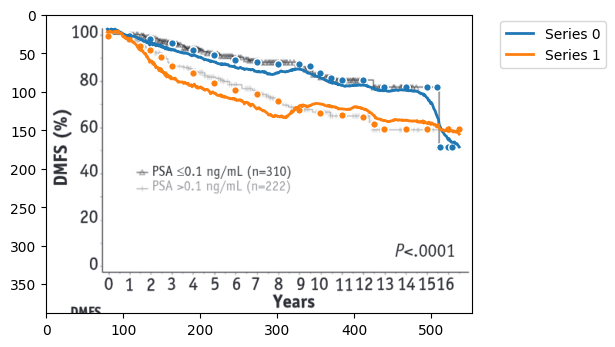

In [29]:
# Setup your calibration
calibration = {'x': {'a': 27.60645, 'b': 79.76774, 'mode': 'linear'},
               'y': {'a': -3.0, 'b': 328.0, 'mode': 'linear'},
               'x_axis_y': 335,
               'y_axis_x': 72}
# Run the inference
snapped = full_image_snapping_inference(
    model,
    "og_img.png",
    "extracted_points.csv",
    calibration
)

# 'snapped' is now a [K, Width] array of precise pixel coordinates

### Colorless model

In [30]:
def apply_cleaning_filter(img_rgb):
    """
    Removes background, color, and noise to leave only curve skeletons.
    """
    # 1. Convert to Grayscale
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    
    # 2. Top-Hat Transform (Removes uneven lighting/background)
    # This keeps only features that are 'smaller' than the 15x15 kernel (the lines)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    
    # 3. Adaptive Thresholding to create a Binary Mask
    # Result: White lines on a Black background
    clean_mask = cv2.adaptiveThreshold(
        blackhat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # 4. (Optional) Dilation to ensure lines aren't too thin for the CNN
    kernel_dil = np.ones((2, 2), np.uint8)
    clean_mask = cv2.dilate(clean_mask, kernel_dil, iterations=1)
    
    return clean_mask # Returns [H, W] (1-channel)

In [31]:
import torch
import torch.nn as nn
from torchvision import models

class VariableCurveSnapperNetColorless(nn.Module):
    def __init__(self, win_w=64, win_h=256, max_curves=8):
        super().__init__()
        # 1. Load ResNet18 backbone
        base = models.resnet18(weights='DEFAULT')
        
        # CHANGE: Input is now 2 channels (1 Gray + 1 Y-Map)
        # Previously it was 4 (3 RGB + 1 Y-Map)
        base.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.backbone = nn.Sequential(*list(base.children())[:-2]) 
        self.compress = nn.Sequential(nn.Conv2d(512, 128, 1), nn.BatchNorm2d(128), nn.ReLU())
        
        # Prior Encoder handles [Batch, 8, win_w]
        self.prior_mlp = nn.Sequential(
            nn.Linear(max_curves * win_w, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        # 2. Dynamic Feature Calculation
        # ResNet18 has a total stride of 32
        h_feat = win_h // 32 # For 256, this is 8
        w_feat = win_w // 32 # For 64, this is 2
        
        self.regressor = nn.Sequential(
            nn.Linear(128 * h_feat * w_feat + 256, 1024), 
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, max_curves), 
            nn.Sigmoid() 
        )

    def forward(self, img, priors):
        # img should now be grayscale [B, 1, H, W]
        b, c, h, w = img.shape
        
        # Create Y-coordinate map (the "ruler")
        y_map = torch.linspace(0, 1, h, device=img.device).view(1, 1, h, 1).expand(b, 1, h, w)
        
        # Concatenate: Gray Channel + Y-Map Channel = 2 Channels
        x = torch.cat([img, y_map], dim=1) 

        v_feat = self.compress(self.backbone(x)).flatten(1)
        p_feat = self.prior_mlp(priors.view(b, -1))
        
        return self.regressor(torch.cat([v_feat, p_feat], dim=1))

In [32]:
import torch
import cv2
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

def apply_cleaning_filter_tensor(img_t):
    """
    Applies the cleaning filter to a batch of tensors [B, 3, H, W].
    Returns a grayscale tensor [B, 1, H, W].
    """
    B, C, H, W = img_t.shape
    # Convert tensor to numpy for OpenCV processing
    imgs_np = (img_t.permute(0, 2, 3, 1).cpu().numpy() * 255).astype(np.uint8)
    processed = []
    
    for i in range(B):
        gray = cv2.cvtColor(imgs_np[i], cv2.COLOR_RGB2GRAY)
        # Top-Hat Transform to isolate thin lines
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
        # Adaptive Threshold for high contrast
        clean_mask = cv2.adaptiveThreshold(
            blackhat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, 11, 2
        )
        processed.append(clean_mask)
    
    # Back to tensor [B, 1, H, W]
    out = torch.from_numpy(np.stack(processed)).unsqueeze(1).float() / 255.0
    return out.to(img_t.device)

def snapping_refined_loss(output, targets, priors, masks, h=256, trust_threshold=5.0):
    # Convert to pixel space
    out_px = output * h
    target_px = targets * h
    # Extract prior value at the center column (index 32)
    prior_px = priors[:, :, 32] * h 

    # 1. Pull toward Ground Truth
    snap_loss = torch.nn.functional.smooth_l1_loss(out_px, target_px, reduction='none')

    # 2. Prior Consistency (Trust accurate priors)
    movement = torch.abs(out_px - prior_px)
    prior_error = torch.abs(prior_px - target_px)
    weight_prior = torch.exp(-prior_error / trust_threshold)
    
    # Penalty for moving a prior that was already good
    consistency_loss = weight_prior * movement
    total_loss = snap_loss + (1.5 * consistency_loss) 
    
    return (total_loss * masks).sum() / (masks.sum() + 1e-8)

def train_snapper(model, val_loader, epochs=20, window_size=64, window_height=256, patience=10):
    # OneCycleLR is ideal for regenerative datasets to settle into high precision
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=1e-4, steps_per_epoch=1, epochs=epochs
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_px_err = 1e9
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        # Fresh data every epoch to prevent overfitting to specific noise patterns
        train_dataset = RealisticVariableSnapDataset(n_samples=10000, win_w=window_size, h=window_height)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        model.train()
        total_train_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for imgs, priors, targets, masks in pbar:
            imgs, priors, targets, masks = imgs.to(device), priors.to(device), targets.to(device), masks.to(device)

            # --- PRE-PROCESSING: Apply cleaning filter ---
            # Converts RGB [B, 3, H, W] to Grayscale [B, 1, H, W]
            imgs_clean = apply_cleaning_filter_tensor(imgs)

            optimizer.zero_grad()
            # Forward pass using 2-channel logic (Gray + Y-Map) inside model
            output = model(imgs_clean, priors)

            loss = snapping_refined_loss(output, targets, priors, masks, h=window_height)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        # --- Validation Phase ---
        model.eval()
        total_val_px_err = 0
        val_curve_count = 0
        with torch.no_grad():
            for imgs, priors, targets, masks in val_loader:
                imgs, priors, targets, masks = imgs.to(device), priors.to(device), targets.to(device), masks.to(device)
                
                # Apply same filter to validation data
                imgs_clean = apply_cleaning_filter_tensor(imgs)
                
                output = model(imgs_clean, priors)
                abs_diff = torch.abs(output * window_height - targets * window_height)
                total_val_px_err += (abs_diff * masks).sum().item()
                val_curve_count += masks.sum().item()

        avg_val_px_err = total_val_px_err / (val_curve_count + 1e-8)
        scheduler.step()
        
        if avg_val_px_err < best_val_px_err:
            best_val_px_err = avg_val_px_err
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_snapper.pth")
            status = f"(Best! {avg_val_px_err:.2f}px)"
        else:
            epochs_no_improve += 1
            status = f"(No improve: {epochs_no_improve})"

        print(f"Summary | LR: {optimizer.param_groups[0]['lr']:.6f} | Val Err: {avg_val_px_err:.2f}px {status}")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load("best_snapper.pth"))
    return model

In [34]:
# --- SETTINGS ---
H = 256
WIN_W = 64
BATCH_SIZE = 32
EPOCHS = 2

# 1. Initialize Datasets (Separate samples for Train and Val)
val_dataset = RealisticVariableSnapDataset(n_samples=1000)

# 2. Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 3. Initialize Model
model = VariableCurveSnapperNetColorless(win_w=WIN_W)

# 4. START TRAINING WITH VALIDATION
print("Starting training with validation...")
trained_model = train_snapper(
    model,
    val_loader,
    epochs=EPOCHS,
    window_size=WIN_W
)

# 5. SAVE AND TEST
torch.save(trained_model.state_dict(), "curve_snapper_colorless.pth")

Starting training with validation...


Epoch 1/2: 100%|██████████| 313/313 [03:18<00:00,  1.58batch/s, loss=39.6196]


Summary | LR: 0.000000 | Val Err: 13.89px (Best! 13.89px)


Epoch 2/2: 100%|██████████| 313/313 [03:31<00:00,  1.48batch/s, loss=26.7174]


Summary | LR: 0.000081 | Val Err: 13.52px (Best! 13.52px)


In [39]:
import torch
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

def prepare_clean_padded_image(img_rgb, calib, pad_w=32):
    """Blanks out background noise and applies reflective padding."""
    H, W, _ = img_rgb.shape
    clean_img = img_rgb.copy()
    
    # Blank everything outside the axes
    y_axis_x = calib.get('y_axis_x', 0)
    x_axis_y = calib.get('x_axis_y', H)
    clean_img[:, :y_axis_x, :] = 255
    clean_img[x_axis_y:, :, :] = 255

    # Reflective padding for edge context
    return cv2.copyMakeBorder(clean_img, 0, 0, pad_w, pad_w, cv2.BORDER_REFLECT)

def full_image_snapping_inference(model, image_path, points_csv, calib, win_w=64, win_h=256, device="cuda",
                                 save_filename="snapped_output_full.csv",
                                 plot_filename="snapped_overlay_full.png"):
    # --- 1. Load Data ---
    img = cv2.imread(image_path)
    if img is None: raise FileNotFoundError(f"Could not load {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W, _ = img_rgb.shape
    df = pd.read_csv(points_csv) #

    # --- 2. Calibration & Range ---
    def to_px(val, cfg):
        if cfg['mode'] == 'log10': return cfg['a'] * np.log10(val) + cfg['b']
        return cfg['a'] * val + cfg['b']

    df['x_px'] = df['x'].apply(lambda x: to_px(x, calib['x']))
    df['y_px'] = df['y'].apply(lambda y: to_px(y, calib['y']))

    min_x = max(0, int(np.floor(df['x_px'].min())))
    max_x = min(W - 1, int(np.ceil(df['x_px'].max())))

    # --- 3. Prep Canvas & Priors ---
    pad = win_w // 2
    img_canvas = prepare_clean_padded_image(img_rgb, calib, pad_w=pad)
    
    series_indices = sorted(df['series_index'].unique())
    priors_full = {}
    for s_idx in series_indices:
        group = df[df['series_index'] == s_idx].sort_values('x_px')
        f = interp1d(group['x_px'], group['y_px'], kind='linear', fill_value='extrapolate')
        priors_full[s_idx] = f(np.arange(W))

    # --- 4. Inference Loop ---
    model.eval()
    model.to(device)
    snapped_data = {s: [] for s in series_indices}
    
    print(f"Running inference from x={min_x} to x={max_x}...")
    for x in tqdm(range(min_x, max_x + 1)):
        x_padded = x + pad
        x0, x1 = x_padded - pad, x_padded + pad

        # Identify vertical center
        current_priors = [priors_full[s][x] for s in series_indices if s in priors_full]
        y_top = int(np.mean(current_priors) - win_h // 2)
        y_top = max(0, min(y_top, H - win_h))

        # Colorless cleaning filter
        img_crop_rgb = img_canvas[y_top:y_top + win_h, x0:x1, :]
        gray = cv2.cvtColor(img_crop_rgb, cv2.COLOR_RGB2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
        clean_mask = cv2.adaptiveThreshold(blackhat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 11, 2)
        
        # Tensor conversion [1, 1, win_h, win_w]
        img_t = torch.from_numpy(clean_mask).float().unsqueeze(0).unsqueeze(0).to(device) / 255.0

        # Prepare Priors for 8 slots
        priors_t = torch.zeros((1, 8, win_w)).to(device)
        for i, s_idx in enumerate(series_indices[:8]):
            start, end = x - pad, x + pad
            if start < 0:
                seg = np.pad(priors_full[s_idx][0:end], (abs(start), 0), mode='edge')
            elif end > W:
                seg = np.pad(priors_full[s_idx][start:W], (0, end - W), mode='edge')
            else:
                seg = priors_full[s_idx][start:end]
            priors_t[0, i] = torch.from_numpy((seg - y_top) / win_h).float()

        with torch.no_grad():
            preds_norm = model(img_t, priors_t)

        preds_px = preds_norm.cpu().numpy()[0] * win_h + y_top
        for i, s_idx in enumerate(series_indices[:8]):
            snapped_data[s_idx].append({'x_px': x, 'y_px': preds_px[i]})

    # --- 5. Save & Overlay ---
    def to_data(px, cfg):
        val = (px - cfg['b']) / cfg['a']
        return 10**val if cfg['mode'] == 'log10' else val

    final_results = []
    plt.figure(figsize=(W/80, H/80))
    plt.imshow(img_rgb)
    colors = plt.cm.get_cmap('tab10', 10)

    for i, s_idx in enumerate(series_indices):
        s_df = pd.DataFrame(snapped_data[s_idx])
        plt.plot(s_df['x_px'], s_df['y_px'], color=colors(i), linewidth=2, label=f"S{s_idx} Snapped")
        
        # Original CSV points as reference dots
        orig = df[df['series_index'] == s_idx]
        plt.scatter(orig['x_px'], orig['y_px'], color=colors(i), s=40, edgecolors='white', zorder=5)

        for _, row in s_df.iterrows():
            final_results.append({
                'series': s_idx, 'x_px': row['x_px'], 'y_px_snapped': row['y_px'],
                'y_data': to_data(row['y_px'], calib['y'])
            })

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f"Full Edge-to-Edge Snapping Results")
    plt.savefig(plot_filename, bbox_inches='tight', dpi=150)
    pd.DataFrame(final_results).to_csv(save_filename, index=False)
    plt.close()
    print(f"Process Complete. CSV: {save_filename} | Plot: {plot_filename}")

In [40]:
calibration = {'x': {'a': 27.60645, 'b': 79.76774, 'mode': 'linear'},
               'y': {'a': -3.0, 'b': 328.0, 'mode': 'linear'},
               'x_axis_y': 335,
               'y_axis_x': 72}
# Run the inference
snapped = full_image_snapping_inference(
    trained_model,
    "og_img.png",
    "extracted_points.csv",
    calibration
)


Running inference from x=79 to x=536...


100%|██████████| 458/458 [00:01<00:00, 377.54it/s]
C:\Users\remi_\AppData\Local\Temp\ipykernel_8188\2873585464.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 10)


Process Complete. CSV: snapped_output_full.csv | Plot: snapped_overlay_full.png
